In [57]:
import numpy as np
import matplotlib.pyplot as plt

We formulate $\mathrm{La1_{x}La2_{\frac{4}{3}-x}TiO_{3}}$.

# Empirically determined parameters

In [58]:
# X-ray wavelength lambda (A)
l = 1.54059

In [59]:
# Parameters of coherent scattering analytically approximated by 5 Gaussians
# https://doi.org/10.1107/S0108767394013292

# Oxygen
a_O = (
    2.960427,
    2.508818,
    0.637853,
    0.722838,
    1.142756,
)
b_O = (
    14.182259,
    5.936858,
    0.112726,
    34.958481,
    0.390240,
)
c_O = 0.027014


# Lanthanum
a_La = (
    19.966018,
    27.329654,
    11.018425,
    3.086696,
    17.335454,
)
b_La = (
    3.197408,
    0.003446,
    19.955492,
    141.381979,
    0.341817,
)
c_La = -21.745489


# Titanium
a_Ti = (
    9.818524,
    1.522646,
    1.703101,
    1.768774,
    7.082555,
)
b_Ti = (
    8.001879,
    0.029763,
    39.885423,
    120.158000,
    0.532405,
)
c_Ti = 0.102473


# Strontium
a_Sr = (
    17.730219,
    9.795867,
    6.099763,
    2.620025,
    0.600053,
)
b_Sr = (
    1.563060,
    14.310868,
    0.120574,
    135.771315,
    0.120574,
)
c_Sr = 1.140251

In [60]:
# La1_{4/3-x}La_{x}TiO3
# src: cif source article

# (x,y,z)
La1 = (0,0,0.5)
La2 = (0,0,0)
Ti = (0.5,0.5,0.2594)
O1 = (0.5,0.5,0.5)
O2 = (0,0.5,0.23)
O3 = (0.5,0,0.2412)
O4 = (0.5,0.5,0)

# Lattice parameters
a = 3.87890
b = 3.86680
c = 7.78660
LTO_abc = (a, b, c)

# Multiplicities
'''
Multiplicity of a ≠ b ≠ c/2 double perovskite
'''
def M_double_perov(hkl):

    # count how many of h,k,l are not zero
    nonzero_cnt = 0
    for i in hkl:
        if i != '0':
            nonzero_cnt += 1

    return np.power(2,nonzero_cnt)

# Functions applicable to all structures

### $hkl$ to $\frac{\sin\theta}{\lambda}$
We find $\frac{\sin\theta}{\lambda}$ from $hkl$ by the interplanar spacing equation
$$
d=\frac{a}{\sqrt{ h^{2}+\left( \frac{a}{b}\cdot k \right)^{2}+\left( \frac{a}{c}\cdot l \right)^{2} }}
$$
which combined with Bragg's law gives
$$
\frac{\sin\theta}{\lambda}=\frac{1}{2d}=\frac{\sqrt{ h^{2}+\left( \frac{a}{b}\cdot k \right)^{2}+\left( \frac{a}{c}\cdot l \right)^{2} }}{2a}
$$

In [61]:
'''
Calculates sin(theta)/lambda (which I call angle data) as a function of hkl given a,b,a
    @param hkl tuple
'''
def sintheta_over_lambda(abc, hkl):
    h = hkl[0]
    k = hkl[1]
    l = hkl[2]
    a = abc[0]
    b = abc[1]
    c = abc[2]

    return np.sqrt(h**2 + (a*k/b)**2 + (a*l/c)**2) / (2*a)



In [62]:
def sintheta(abc,hkl):
    return l * sintheta_over_lambda(abc,hkl)

def costheta(abc,hkl):
    return np.sqrt(1 - sintheta(abc,hkl)**2)

### Lorentz polarization
We formulate the Lorentz factor as $$
\frac{{1+\cos(\theta)^{2}}}{\sin(\theta)^{2}\cos(\theta)}.
$$
src: XRD book

In [63]:
'''
Lorentz-polarization factor at direction hkl
    @param hkl tuple
'''
def lorentz(hkl,abc):
    return (1+costheta(abc,hkl)**2)/(sintheta(abc,hkl)**2 * costheta(abc,hkl))


### Coherent scattering atomic form factor
$f(\theta)$ is the coherent scattering factor. Its intensity as a function of $\theta$ is analytically approximated by $N=5$ gaussians:
$$f_0 (\sin \theta / \lambda ) = \sum _{i=1}^N a_i \exp \left ( −b_i \frac {\sin ^2 \theta }{ \lambda ^2} \right ) + c.$$
The 11 params $a_{i},b_{i},c$ are defined & cited up there.

In [64]:
'''
Atomic form factors of given atom (Coherent scattering)
 @param hkl tuple
 @param ai tuple
 @param bi tuple
 @param c float
 @param abc lattice parameters; required to calculate sin(theta)/lambda
'''
def f(hkl,ai,bi,c,abc):
    f0 = c
    for i in range(5):
        f0 += ai[i] * np.exp(- bi[i] * sintheta_over_lambda(abc, hkl) ** 2)
    return f0

### Exp of Atomic positional factor

$$\exp \bigl [ 2\pi \mathrm {i} \big ( hx_j + ky_j + lz_j \big ) \bigr ]$$

In [65]:
'''
Exponent containing atomic positional params in structure factor
 @param hkl tuple
 #param xyz tuple
'''
def exphkl(hkl,xyz):
    h = hkl[0]
    k = hkl[1]
    l = hkl[2]

    ans = np.exp(2 * np.pi * 1j * (h*xyz[0] + k*xyz[1] + l*xyz[2]))

    return ans

## Intensity

$$I_{hkl}=\mathrm{Multiplicity} \cdot \text{Lorentz }\cdot |S_{hkl}|^{2}$$

In [66]:
'''
 intensity of the peak hkl when La distribution described by x
 @param hkl tuple
 @param x float
 @param M dict
 @param S(hkl,x)
'''
def I(hkl,abc,x,M,S):
    return M(hkl) * lorentz(hkl,abc) * (np.absolute(S(hkl, x)) ** 2)

# Structure-specific functions

### L2/3TO: Order parameter and structure factor
Translate $x$ in $\mathrm{La1_{x}La2_{\frac{4}{3}-x}TiO_{3}}$ to Uchino's order parameter $\sigma$.
$$S=(x)F_{\text{La1}}+\left( \frac{4}{3}-x \right)F_{\text{La2}}+F_{\text{Ti}}+F_{\text{O}}$$


In [67]:
'''
Calculates Uchino's order parameter given x
@param x float
'''
def sigma(x):
    return 2-3*x

def x_from_sigma(sigma):
    return (2-sigma)/3

In [68]:
'''
La2/3TiO3 Structure factor of the peak hkl, containing all basis atoms, when La distribution described by x
 @param hkl tuple
 @param x float
'''
def L2p3TO_S(hkl, x):
    ans = x * f(hkl,a_La,b_La,c_La,LTO_abc) * exphkl(hkl,La1) \
          + (4/3 - x) * f(hkl,a_La,b_La,c_La,LTO_abc) * exphkl(hkl,La2) \
          + f(hkl,a_Ti,b_Ti,c_Ti,LTO_abc) * exphkl(hkl,Ti) \
          + f(hkl,a_O,b_O,c_O,LTO_abc) * (exphkl(hkl,O1) + exphkl(hkl,O2) + exphkl(hkl,O3) + exphkl(hkl,O4)) # four basis O atoms
    return ans

# Intensity predictions

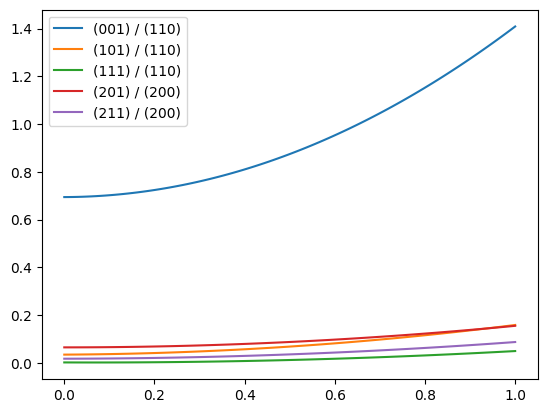

In [69]:
x = np.linspace(1/3,2/3,num=100)
s = sigma(x)

i001 = I((0,0,1), LTO_abc, x, M_double_perov, L2p3TO_S)

i101 = I((1,0,1), LTO_abc, x, M_double_perov, L2p3TO_S)

i111 = I((1,1,1), LTO_abc, x, M_double_perov, L2p3TO_S)

i110 = I((1,1,0), LTO_abc, x, M_double_perov, L2p3TO_S) \
     + I((1,0,2), LTO_abc, x, M_double_perov, L2p3TO_S) \
     + I((0,1,2), LTO_abc, x, M_double_perov, L2p3TO_S)
i201 = I((2,0,1), LTO_abc, x, M_double_perov, L2p3TO_S)
i211 = I((2,1,1), LTO_abc, x, M_double_perov, L2p3TO_S)
i200 = I((2,0,0), LTO_abc, x, M_double_perov, L2p3TO_S)

plt.plot(s, i001/i110,label='(001) / (110)')
plt.plot(s, i101/i110,label='(101) / (110)')
plt.plot(s, i111/i110,label='(111) / (110)')

plt.plot(s, i201/i200,label='(201) / (200)')
plt.plot(s, i211/i200,label='(211) / (200)')

plt.legend()
plt.savefig('/Users/beep/Desktop/La2-3/La2-3_Uchino_Fig5_reconstruction')

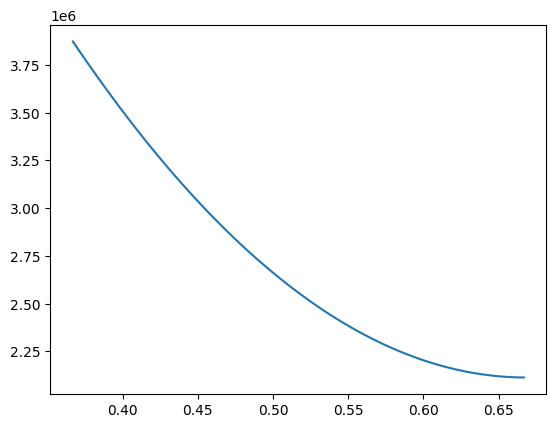

In [75]:
plt.plot(x[10:],i001[10:])